# Predict Student Performance from Game Play

In [41]:
import numpy as np
import pandas as pd
import lightgbm as gbm
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from dask import dataframe as dd
from typing import Optional, Dict, List, Tuple

import os
import sys
sys.path.append("./")

# Define Directories

In [2]:
ARTIFACT_FOLDER = "../artifacts"
DATA_FOLDER = "../data"

# Import Data

In [38]:

### Pandas ###
# x_train = pd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
# y_train = pd.read_csv(os.path.join(DATA_FOLDER, "train_labels.csv"))

### Dask ### 
x_train = dd.read_csv(os.path.join(DATA_FOLDER, "train.csv"))
y_train = dd.read_csv(os.path.join(DATA_FOLDER, "train_labels.csv"))

In [39]:
print(f"Total number of rows in training dataset: {len(x_train.index)}")
print(f"Total number of columns in training dataset: {x_train.shape[1]}")
print()
print(f"Total number of answered questions in training dataset: {len(y_train.index)}")

Total number of rows in training dataset: 26296946
Total number of columns in training dataset: 20

Total number of answered questions in training dataset: 424116


In [4]:
x_train.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [40]:
y_train.head(5)

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
x_train.dtypes

session_id          int64
index               int64
elapsed_time        int64
event_name         object
name               object
level               int64
page              float64
room_coor_x       float64
room_coor_y       float64
screen_coor_x     float64
screen_coor_y     float64
hover_duration    float64
text               object
fqid               object
room_fqid          object
text_fqid          object
fullscreen          int64
hq                  int64
music               int64
level_group        object
dtype: object

In [13]:
%%time

x_train.isnull().sum().compute()

CPU times: user 1min 15s, sys: 5.47 s, total: 1min 21s
Wall time: 32 s


session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

In [26]:
%time
for feature in x_train.columns:
    column_data = x_train[feature]
    print(f"Number of unique data for feature {feature}: {len(x_train[feature].unique().compute())}")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Number of unique data for feature session_id: 23562
Number of unique data for feature index: 20348
Number of unique data for feature elapsed_time: 5042639
Number of unique data for feature event_name: 11
Number of unique data for feature name: 6
Number of unique data for feature level: 23
Number of unique data for feature page: 8
Number of unique data for feature room_coor_x: 17438694
Number of unique data for feature room_coor_y: 13651024
Number of unique data for feature screen_coor_x: 57925
Number of unique data for feature screen_coor_y: 102592
Number of unique data for feature hover_duration: 24102
Number of unique data for feature text: 598
Number of unique data for feature fqid: 129
Number of unique data for feature room_fqid: 19
Number of unique data for feature text_fqid: 127
Number of unique data for feature fullscreen: 2
Number of unique data for feature hq: 2
Number of unique data for feature music: 2
Number of

# EDA

In [44]:
def count_plot(data, feature: str, split_by: Optional[str] = None):
    sns.countplot(data = data, x = feature, hue = split_by)
    plt.title(feature)

## Target Label Distribution

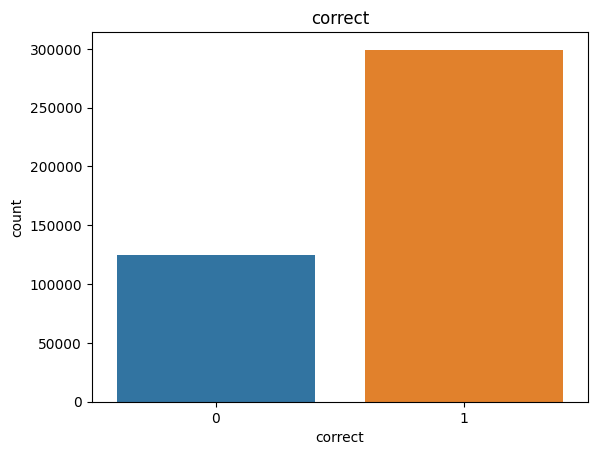

In [55]:
count_plot(data = y_train.compute(), feature = "correct")

### Check index

In [28]:
subdata = x_train[["session_id", "index", "level_group"]]
subdata.groupby(["session_id", "level_group"]).max().compute()

index
session_id        level_group       
20090312431273200 0-4            164
                  13-22          931
                  5-12           470
20090312433251036 0-4            138
                  13-22         1875
...                              ...
22100219442786200 13-22          920
                  5-12           453
22100221145014656 0-4            210
                  13-22         1604
                  5-12           799

[70686 rows x 1 columns]

### Music and Full Screen

In [33]:
subdata = x_train[["session_id", "fullscreen"]]
grouptable = subdata.groupby("session_id")["fullscreen"].mean().compute()

In [37]:
subdata

,session_id,fullscreen
npartitions=73,,
,int64,int64
,...,...
...,...,...
,...,...
,...,...


# Preprocessing

## Missing Data Imputation

## One-Hot Encoding and Scaling

## Feature Engineering

# Model Building

In [ ]:
xgb = XGBoostClassifier


# Inference